# Conditional-GAN on CelebA Dataset

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/04_gan/03_cgan/cgan.ipynb)
- Dataset: [Kaggle](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)

In [1]:
import os
import time
from IPython import display
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as Transforms
import torchvision.utils as vutils
import torch.autograd as autograd

from torchsummary import summary
from torcheval import metrics as Metrics

## 0. Train parameters

In [2]:
DATA_DIR = '../../data/CelebFaces/img_align_celeba/img_align_celeba/'
ATTR_DIR = '../../data/CelebFaces/list_attr_celeba.csv'
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
Z_DIM = 128
LR = 2e-4
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
EPOCHS = 25
CRITIC_STEPS = 3
GP_WEIGHT = 10.0

LABEL = 'Smiling'
CLASSES = 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


## 1. Prepare dataset

In [3]:
class CelebA(Dataset):
    def __init__(self, image_dir, label_dir):
        super().__init__()

        self.transform = Transforms.Compose([
                Transforms.ToTensor(),
                Transforms.Resize(size=IMAGE_SIZE, antialias=True),
                Transforms.CenterCrop(size=IMAGE_SIZE),
                Transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])

        data_attr = pd.read_csv(ATTR_DIR)[:20000]
        imgs = data_attr['image_id']
        
        self.length = len(data_attr)

        # Store images in this class to save time in training
        self.imgs = torch.zeros(size=(self.length, CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
        for i, file_name in enumerate(imgs):
            img = self.transform(Image.open(image_dir + file_name))
            self.imgs[i] = img

        labels = torch.tensor(data_attr[LABEL])
        labels = torch.where(labels==1, 1, 0)
        self.labels = F.one_hot(labels, num_classes=CLASSES)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.imgs[index], self.labels[index].type(torch.float32)

In [4]:
def get_dataloader():
    print('Loading dataset...')
    prev_time = time.time()
    celeb_data = CelebA(DATA_DIR, ATTR_DIR)
    celeb_dataloader = DataLoader(celeb_data, BATCH_SIZE, shuffle=True,
                                  num_workers=8, pin_memory=True, pin_memory_device=DEVICE)
    curr_time = time.time()
    print('Total loading time {:.2f} min'.format((curr_time - prev_time) / 60))
    print('Train data size: ', len(celeb_data))
    print('Num. train batchs: ', len(celeb_dataloader))
    return celeb_dataloader

In [5]:
face_dataloader = get_dataloader()

Loading dataset...
Total loading time 0.13 min
Train data size:  20000
Num. train batchs:  157


In [6]:
def display_imgs(imgs):
    plt.figure(figsize=(16, 3))
    plt.axis('off')
    plt.imshow(np.transpose(vutils.make_grid(imgs[:8], nrow=8, padding=2, normalize=True).detach().cpu(),(1,2,0)))

# plot training records
def show_records(history):
    plt.figure(figsize=(16, 3))
    for i, key in enumerate(history):
        ax = plt.subplot(1, len(history), i+1)
        ax.plot(history[key])
        ax.set_title(key)
    plt.show()

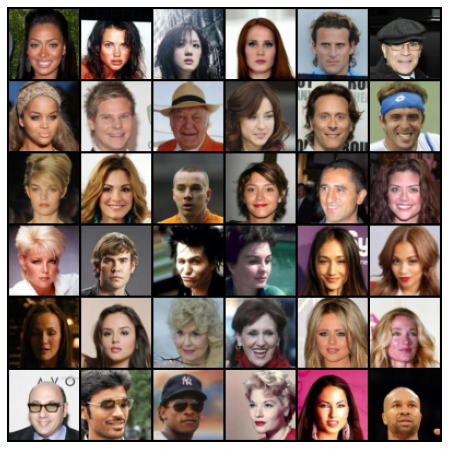

In [7]:
test_sample, labels = next(iter(face_dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(np.transpose(vutils.make_grid(test_sample[:36], nrow=6, padding=2, normalize=True).cpu(),(1,2,0)))

## 2. Building WGAN

In [9]:
class Critic(nn.Module):

    def __init__(self):
        super().__init__()
        channel_list = [CHANNELS + CLASSES, 64, 128, 256, 512]

        # Convolutional layers
        self.conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            self.conv_layers.add_module(f'conv_{i}',
                                        self.get_conv_block(channel_list[i], channel_list[i+1], bool(i)))

        # Layers for output -> (Batch_size, 1)
        self.output_layer = nn.Sequential(
            nn.Conv2d(in_channels=channel_list[-1], out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Flatten()
        )


    def forward(self, imgs, labels):
        x = torch.cat([imgs, labels], dim=1)
        x = self.conv_layers(x)
        x = self.output_layer(x)
        return x


    def get_conv_block(self, in_ch, out_ch, use_dropout):
        conv_layer = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=4,
                               stride=2, padding=1)
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        dropout = nn.Dropout2d(0.3)
        if use_dropout:
            return nn.Sequential(conv_layer, leaky_relu, dropout)
        else:
            return nn.Sequential(conv_layer, leaky_relu)

critic = Critic().to(DEVICE)
summary(critic, [(3, 64, 64), (2, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           5,184
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
         LeakyReLU-4          [-1, 128, 16, 16]               0
         Dropout2d-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
         LeakyReLU-7            [-1, 256, 8, 8]               0
         Dropout2d-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
        LeakyReLU-10            [-1, 512, 4, 4]               0
        Dropout2d-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,193
          Flatten-13                    [-1, 1]               0
Total params: 2,766,785
Trainable param

In [10]:
class Generator(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        channel_list = [z_dim + CLASSES, 512, 256, 128, 64]

        # Convolution transpose layers
        self.trans_conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            stride = 2 if i else 1
            padding = 1 if i else 0
            trans_conv_block = self.get_transpose_conv_block(channel_list[i], channel_list[i + 1],
                                                             stride, padding)
            self.trans_conv_layers.add_module(f'trans_conv_block_{i}', trans_conv_block)

        # Output layers -> (-1, 1, 64, 64)
        self.output_layers = nn.Sequential(
                nn.ConvTranspose2d(in_channels=channel_list[-1], out_channels=CHANNELS,
                                   kernel_size=4, stride=2, padding=1, bias=False),
                nn.Tanh()
        )


    def forward(self, latents, labels):
        x = torch.cat([latents, labels], dim=1)
        x = x.reshape(x.shape[0], x.shape[-1], 1, 1)
        x = self.trans_conv_layers(x)
        x = self.output_layers(x)
        return x


    def get_transpose_conv_block(self, in_ch, out_ch, stride=2, padding=1):
        transpose_conv = nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch,
                                            kernel_size=4, stride=stride, padding=padding, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1)
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        return nn.Sequential(transpose_conv, batch_norm, leaky_relu)

generator = Generator(Z_DIM).to(DEVICE)
summary(generator, [(Z_DIM,), (CLASSES, )])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,064,960
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        LeakyReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [11]:
class WGAN_GP(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = Generator(Z_DIM).to(DEVICE)
        self.critic = Critic().to(DEVICE)
        self.critic_steps = CRITIC_STEPS

    def gradient_penalty(self, real_imgs, fake_imgs, labels_img_mat):
        if not self.critic.training:
            self.critic.train()
        alpha = torch.randn(size=(1,), device=DEVICE)
        diff = real_imgs - fake_imgs
        interpolates = real_imgs + alpha * diff

        interpolates.requires_grad_()
        preds = self.critic(interpolates, labels_img_mat)
        grads = autograd.grad(outputs=preds, inputs=interpolates,
                              grad_outputs=torch.ones_like(preds),
                              create_graph=True, retain_graph=True,
                              only_inputs=True)[0]

        gp = (torch.norm(grads, dim=1) - 1) ** 2
        return gp.mean()


## 3. Define the model, objective, and optimizers

In [12]:
wgan_gp = WGAN_GP().to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    # It is important to use eager backend here to avoid
    # distribution mismatch in training and predicting
    wgan_gp = torch.compile(wgan_gp, backend='eager')
    print('model compiled')

c_optim = torch.optim.Adam(params=wgan_gp.critic.parameters(),
                           lr=LR, betas=[ADAM_BETA_1, ADAM_BETA_2])

g_optim = torch.optim.Adam(params=wgan_gp.generator.parameters(),
                           lr=LR, betas=[ADAM_BETA_1, ADAM_BETA_2])

train_metrics = {
    'c_loss': Metrics.Mean(),
    'c_wass_loss': Metrics.Mean(),
    'c_gp': Metrics.Mean(),
    'g_loss': Metrics.Mean()
}

model compiled


## 4. Get dataloader

In [13]:
# face_dataloader = get_dataloader()

## 5. Trainer function

In [14]:
def trainer(model, dataloader, c_optim, g_optim, train_metrics):

    model.train() # Set model to train mode

    for metric in train_metrics.values():
        metric.reset()

    num_passes = len(dataloader)

    for i in tqdm(range(num_passes)):

        # 1. Train Critic
        for _ in range(model.critic_steps):
            c_optim.zero_grad()

            # 1.1 Train critic on real data
            real_imgs, labels = next(iter(dataloader))

            labels_img_mat = labels[:, :, None, None]
            labels_img_mat = labels_img_mat.repeat(1, 1, IMAGE_SIZE, IMAGE_SIZE)
            
            real_imgs = real_imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            labels_img_mat = labels_img_mat.to(DEVICE) # Image matrix format of labels
            
            real_preds = model.critic(real_imgs, labels_img_mat)
            # Gradient ascent for real loss, therefore negative
            real_loss = -real_preds.mean()

            # 1.2 Train critic on fake data
            latents = torch.randn(size=(len(real_imgs), Z_DIM), device=DEVICE)
            fake_imgs = model.generator(latents, labels)
            fake_preds = model.critic(fake_imgs, labels_img_mat)
            # Gradient descent for fake loss, therefore positive
            fake_loss = fake_preds.mean()

            # 1.3 Gradient penalty
            c_gp = model.gradient_penalty(real_imgs, fake_imgs, labels_img_mat)

            # put all losses together
            c_wass_loss = fake_loss + real_loss
            c_loss = c_wass_loss + GP_WEIGHT * c_gp
            c_loss.backward()
            c_optim.step()


        # 2. Train Generator
        g_optim.zero_grad()
        latents = torch.randn(size=(len(real_imgs), Z_DIM), device=DEVICE)
        fake_imgs = model.generator(latents, labels)
        fake_preds = model.critic(fake_imgs, labels_img_mat)

        # Gradient ascent for fake loss, therefore negative
        g_loss = -fake_preds.mean()
        g_loss.backward()
        g_optim.step()

        train_metrics['c_wass_loss'].update(c_wass_loss.detach().cpu())
        train_metrics['c_gp'].update(c_gp.detach().cpu())
        train_metrics['c_loss'].update(c_loss.detach().cpu())
        train_metrics['g_loss'].update(g_loss.detach().cpu())

        del real_imgs, real_preds, fake_preds

    return fake_imgs

## 6. Train WGAN-GP

Epoch: 2	epoch time 1.61 min
	 c_loss: -1947.7836 | c_wass_loss: -2918.1228 | c_gp: 97.0339 | g_loss: -17252.1921 | 


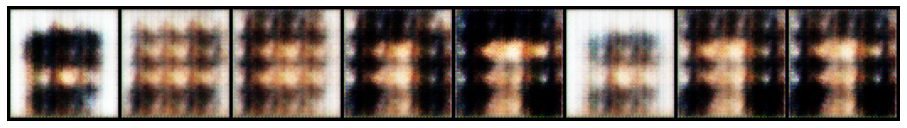

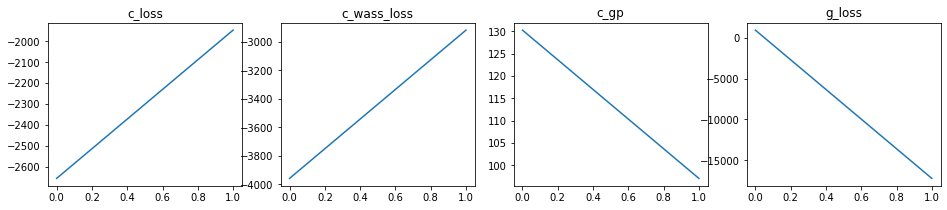

  0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
history = defaultdict(list)

for i in range(EPOCHS):
    prev_time = time.time()
    generated_imgs = trainer(wgan_gp, face_dataloader, c_optim, g_optim, train_metrics)
    curr_time = time.time()

    for key, value in train_metrics.items():
        history[key].append(value.compute().item())

    display.clear_output(wait=True)

    print('Epoch: {}\tepoch time {:.2f} min'.format(i+1, (curr_time - prev_time) / 60))
    metrics = [f'{key}: {value.compute().item() / 1000:.4f} | ' for key, value in train_metrics.items()]
    print('\t', ''.join(metrics))

    generated_imgs = generated_imgs.detach().cpu()
    display_imgs(generated_imgs)
    show_records(history)

    # if i % 10 == 0:
        # torch.save(wgan_gp.state_dict(), './models/wgan_gp.pt')

In [15]:
# wgan_gp.load_state_dict(torch.load('./models/wgan_gp.pt'))

<All keys matched successfully>

## 7. Generate Images

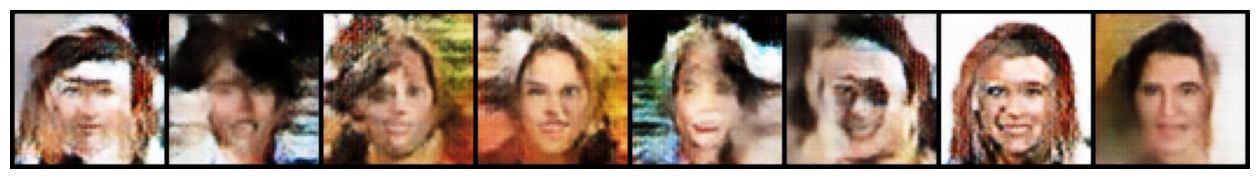

In [16]:
# z_samples = torch.randn(size=(8, Z_DIM), device=DEVICE)
# wgan_gp.eval()
# with torch.no_grad():
#     generated_imgs = wgan_gp.generator(z_samples)
# generated_imgs = generated_imgs.detach().cpu()
# display_imgs(generated_imgs)